In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import cv2

2022-05-10 15:40:01.903217: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
masks_dir = './data/segmentation/testannot'
label_data = './data/labels.csv'

masks = os.listdir(masks_dir)
label_df = pd.read_csv(label_data)
label_df.set_index('img_name', inplace=True)

In [3]:
label_df.head()

,leaf_weight
img_name,
CASE25_01.png,157.091
CASE25_02.png,179.448
CASE25_03.png,201.426
CASE25_04.png,215.627
CASE25_05.png,223.540


In [4]:
label_df = label_df.sort_values(by='img_name', axis=0)
masks.sort()

In [5]:
label_df.head()

,leaf_weight
img_name,
CASE01_01.png,49.193
CASE01_02.png,59.764
CASE01_03.png,72.209
CASE01_04.png,85.737
CASE01_05.png,102.537


In [6]:
pixels = []

for mask in masks :
    path = os.path.join(masks_dir, mask)
    img = cv2.imread(path)
    
    # non zero pixel 수 계산
    pix = np.count_nonzero(img)
    pixels.append(pix)
    
label_df['pixels'] = pixels

In [7]:
label_df.head()

,leaf_weight,pixels
img_name,,
CASE01_01.png,49.193,19827
CASE01_02.png,59.764,23790
CASE01_03.png,72.209,28659
CASE01_04.png,85.737,33729
CASE01_05.png,102.537,38553


In [8]:
label_df.to_csv('./pixels_num.csv')

In [9]:
x_data = label_df['pixels'].values
x_data = x_data.reshape(-1,1)
y_data = label_df['leaf_weight'].values
y_data = y_data.reshape(-1,1)

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_x.fit(x_data)
scaler_y.fit(y_data)

scaled_x = scaler_x.transform(x_data)
scaled_y = scaler_y.transform(y_data)

In [11]:
scaled_x.shape

(1592, 1)

In [12]:
scaled_y.shape

(1592, 1)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import Adam,SGD
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(1,)),
#     Dense(64, activation='relu'),
#     Dense(1)
# ])
model = Sequential()
model.add(Dense(input_dim=1, units=1, activation='linear', use_bias=True))

model.summary()

2022-05-10 15:40:13.281127: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-10 15:40:13.282225: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-10 15:40:13.341233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 15:40:13.341854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-05-10 15:40:13.341886: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-10 15:40:13.343765: I tensorflow/stream_executor/platform/default/dso_loade

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [14]:
LEARNING_RATE = 1e-4
model.compile(loss='mse',
             optimizer=SGD(learning_rate=LEARNING_RATE),
             metrics=['mse'])

history = model.fit(scaled_x,
                    scaled_y,
                   epochs=5000,
                   verbose=0,
                   validation_split=0.2)

2022-05-10 15:40:15.665124: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-10 15:40:15.684949: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz
2022-05-10 15:40:15.905721: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


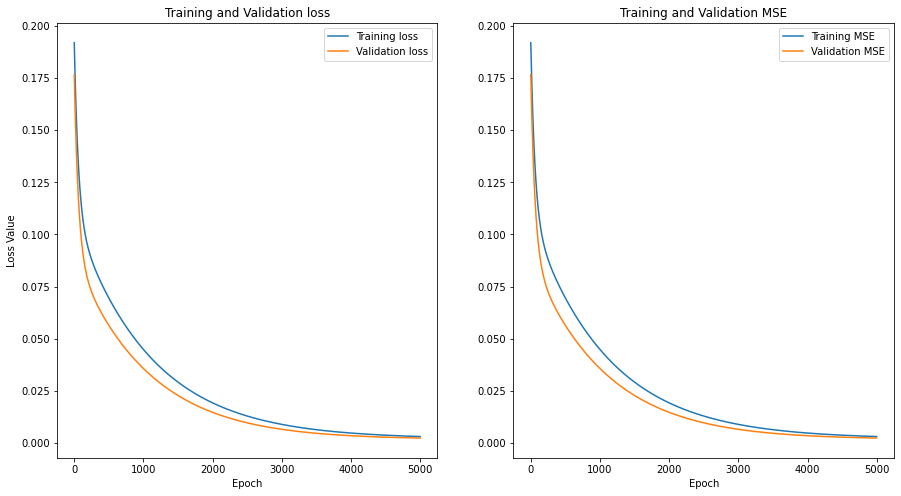

In [15]:
EPOCHS = 5000
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['mse']
val_acc = history.history['val_mse']

epochs = range(EPOCHS)

fig = plt.figure(figsize=(15,8))
ax1= fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, label='Training loss')
ax1.plot(epochs, val_loss, label='Validation loss')
ax1.set_title('Training and Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss Value')
ax1.legend()


ax2= fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, label='Training MSE')
ax2.plot(epochs, val_acc, label='Validation MSE')
ax2.set_title('Training and Validation MSE')
ax2.set_xlabel('Epoch')
ax2.legend()


plt.show()

In [16]:
model.save('./Model_Save/Simple_linear_regression_with_pixels_epoch5000.h5')

---

In [17]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(x_data,y_data)

LinearRegression()

In [18]:
pred = lr.predict(x_data)

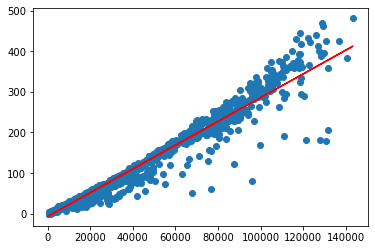

In [19]:
plt.scatter(x_data.squeeze(), y_data)
plt.plot(x_data.squeeze(), pred, 'r')
plt.show()

# TEST IMAGES


In [20]:
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.data import Dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

import albumentations as A
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [21]:
def get_data(data_dir):
    # get image path
    img_path = os.listdir(data_dir)
    try :
        img_path.remove('.ipynb_checkpoints')
    except:
        pass
    img_path_list = [os.path.join(data_dir, x) for x in img_path]
    img_path_list = sorted(img_path_list)
    return img_path_list  # img 들의 경로를 리스트로 리턴

def load_test_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0
    return img

def create_test_dataset(img_dir, target_size, batch_size=None) :
    x_img_dir = get_data(img_dir)
    file_name = [x.split('/')[-1][:-4] for x in x_img_dir]
    
    x_img = []

    for i in tqdm(x_img_dir,
                     total=len(x_img_dir),
                     position=0,
                     leave=True):
        img = load_test_img_numpy(i, target_size)
        x_img.append(img)

    dataset = Dataset.from_tensor_slices(x_img)
    
    if batch_size is not None :
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
       
    return dataset, file_name

def step(num) :
    if num < 0.5 :
        return 0
    else :
        return 1
step_func = np.vectorize(step)

def transform_and_save(predicted_images, save_dir, file_names) :
    transformed = []
    
    for img, name in tqdm(zip(predicted_images, file_names),
                   total=len(predicted_images)):
        image = step_func(img)
        transformed.append(image)
        cv2.imwrite(os.path.join(save_dir, name+'.png'), image)
    print('save done!')

In [27]:
x_test_dir = './data/test/image'
IMAGE_SIZE=256
PRED_BATCHSIZE = 10

test_dataset, file_names = \
create_test_dataset(x_test_dir, (IMAGE_SIZE, IMAGE_SIZE), PRED_BATCHSIZE)

  0%|          | 0/460 [00:00<?, ?it/s]

In [29]:
test_dataset

<RepeatDataset shapes: (10, 256, 256, 3), types: tf.float32>

In [30]:
file_names

['001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',


In [31]:
from tensorflow.keras.models import load_model
seg_model = load_model('./Model_Save/segmentation_epoch3.h5')

In [32]:
STEPS = len(get_data(x_test_dir)) / PRED_BATCHSIZE # 460 // 10

prediction = seg_model.predict(test_dataset,
                          batch_size = PRED_BATCHSIZE,
                          steps=STEPS)

2022-05-10 15:51:44.626277: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [33]:
y_test_dir = './data/test/test image annot'
transform_and_save(prediction, y_test_dir, file_names)

  0%|          | 0/460 [00:00<?, ?it/s]

save done!


In [35]:
masks = os.listdir(y_test_dir)
masks.sort()

In [36]:
masks

['001.png',
 '002.png',
 '003.png',
 '004.png',
 '005.png',
 '006.png',
 '007.png',
 '008.png',
 '009.png',
 '010.png',
 '011.png',
 '012.png',
 '013.png',
 '014.png',
 '015.png',
 '016.png',
 '017.png',
 '018.png',
 '019.png',
 '020.png',
 '021.png',
 '022.png',
 '023.png',
 '024.png',
 '025.png',
 '026.png',
 '027.png',
 '028.png',
 '029.png',
 '030.png',
 '031.png',
 '032.png',
 '033.png',
 '034.png',
 '035.png',
 '036.png',
 '037.png',
 '038.png',
 '039.png',
 '040.png',
 '041.png',
 '042.png',
 '043.png',
 '044.png',
 '045.png',
 '046.png',
 '047.png',
 '048.png',
 '049.png',
 '050.png',
 '051.png',
 '052.png',
 '053.png',
 '054.png',
 '055.png',
 '056.png',
 '057.png',
 '058.png',
 '059.png',
 '060.png',
 '061.png',
 '062.png',
 '063.png',
 '064.png',
 '065.png',
 '066.png',
 '067.png',
 '068.png',
 '069.png',
 '070.png',
 '071.png',
 '072.png',
 '073.png',
 '074.png',
 '075.png',
 '076.png',
 '077.png',
 '078.png',
 '079.png',
 '080.png',
 '081.png',
 '082.png',
 '083.png',
 '08

In [37]:
def calc_pixels_from_mask(masks_dir, masks) :
    pixels = []

    for mask in masks :
        path = os.path.join(masks_dir, mask)
        img = cv2.imread(path)

        # non zero pixel 수 계산
        pix = np.count_nonzero(img)
        pixels.append(pix)

    return pixels

In [38]:
pixels = calc_pixels_from_mask(y_test_dir, masks)

In [39]:
len(pixels)

460

In [40]:
pixels = np.array(pixels).reshape(-1,1)

In [41]:
scaled_pixels = scaler_x.transform(pixels)
scaled_pixels.shape

(460, 1)

In [42]:
pred_leaf_weight = model.predict(scaled_pixels)

In [44]:
pred_leaf_weight.shape

(460, 1)

In [45]:
pred = scaler_y.inverse_transform(pred_leaf_weight)

In [47]:
pred.shape

(460, 1)

In [48]:
submission = pd.read_csv('./data/sample_submission.csv')

In [50]:
submission.head()

,img_name,leaf_weight
0,001.png,0
1,002.png,0
2,003.png,0
3,004.png,0
4,005.png,0


In [52]:
submission['leaf_weight'] = pred.squeeze()

In [53]:
submission

,img_name,leaf_weight
0,001.png,88.802612
1,002.png,273.080261
2,003.png,9.705936
3,004.png,82.559708
4,005.png,92.805237
...,...,...
455,456.png,73.471649
456,457.png,100.235481
457,458.png,60.000134
458,459.png,83.239258


In [54]:
submission.to_csv('./data/segmentation_pixel_linear.csv', index=False)